In [36]:
import pymongo
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm
import talib
import gc
from typing import Union


In [37]:
class Chast:

    def __init__(self, client, db_name='Fields'):
        self.client = client
        self.db = client[db_name]
        self._config()
        self.data = dict()
        self.results = dict()
        self.initial_capital = 100000000
        
    def _config(self):
        # 設定繪圖、TQDM讀取條、小數點位數、顯示視窗長度
        pd.options.plotting.backend = "matplotlib"
        tqdm.pandas(desc="progress-bar")
        plt.rcParams['font.family'] = ['Microsoft JhengHei'] # 中文標籤
        plt.rcParams['axes.unicode_minus'] = False # 負號
        pd.set_option('display.max_rows', 200)
        pd.set_option('display.float_format', lambda x: '%.3f' % x)
        pd.options.display.float_format = '{:,.4f}'.format

    def _result(self):
        pf = self.results['PROFIT']
        com = self.results['COMMISION']
        self.results['RESULT'] = (pf - com).sum(axis=1).cumsum()

    def _maxdrawdown(self):
        se = self.results['RESULT']
        mdd = 0
        mdd_ = list()
        h = 0
        for i in se:
            if i > h:
                h = i
            mdd = i - h
            mdd_.append(mdd)
        self.results['MDD'] = pd.Series(mdd_, index=se.index, name='MDD')

    def _sharpe_ratio(self, roll: int = 120):
        """
        計算Sharpe ratio
        預設roll 120天=半年
        roll
        """
        pf = self.results['RESULT']
        self.results['SHARPE RATIO'] = (pf-pf.shift(1)).rolling(roll).apply(lambda x: x.mean() / x.std() if x.std() != 0 else 0, raw=True)
    
    def _holding(self):

        bs = self.results['BS']
        if '收盤價' in self.data.keys():
            holding = bs.fillna(0) * self.data['收盤價'].loc[bs.index, bs.columns] * 1000
        else:
            self.get_from_mongo('收盤價')
            holding = bs.fillna(0) * self.data['收盤價'].loc[bs.index, bs.columns] * 1000
        self.results['HOLDING'] = holding

    def _capital(self):
        self.results['CAPITAL NET'] = self.results['CAPITAL'][:-1]


    def get_chart(self):
        keys = self.results

        self._result()
        self._maxdrawdown()
        self._holding()
        self._sharpe_ratio(120)
        self._capital()

        fig ,ax = plt.subplots(6, 1, figsize=(16, 16), gridspec_kw={'height_ratios': [2, 1, 1, 1, 1, 1]})
        
        if 'RESULT' in keys:
            ax[0].plot(self.results['RESULT'][:-1])
            ax[0].set_title(f'累計損益')
            ax[0].grid(True)
            ax[0].yaxis.set_major_formatter('{x:,.0f}')
            ax[0].xaxis.set_minor_locator(mdates.YearLocator())
        if 'MDD' in keys:
            ax[1].plot(self.results['MDD'][:-1], color='orange')
            ax[1].grid(True)
            ax[1].set_title('MaxDrawdown')
            ax[1].yaxis.set_major_formatter('{x:,.0f}')
        if 'BS' in keys:
            ax[2].plot(self.results['BS'].fillna(0).astype(bool).sum(axis=1)[:-1], color='green')
            ax[2].set_title('累計股數')
        if 'HOLDING' in keys:
            ax[3].plot(self.results['HOLDING'].sum(axis=1)[:-1], color='lightgreen')
            ax[3].set_title('累計市值')
            ax[3].yaxis.set_major_formatter('{x:,.0f}')
        if 'SHARPE RATIO' in keys:
            ax[4].plot(self.results['SHARPE RATIO'][:-1], color='lightblue')
            ax[4].grid(True)
            ax[4].set_title('Rolling Sharpe Ratio')
            ax[4].yaxis.set_major_formatter('{x:.3f}')
        if 'CAPITAL' in keys:
            ax[5].plot(self.results['CAPITAL NET'][:-1], color='darkgreen')
            ax[5].grid(True)
            ax[5].set_title('Capital')
            ax[5].yaxis.set_major_formatter('{x:,.0f}')

        fig.tight_layout()
        plt.show()        

    def get_from_mongo(self, elements,
     start: Union[datetime.datetime, None]=None, 
     end: Union[datetime.datetime, None]=None):
        """
        elements: Element, 表示要在Mongo中抓哪些資料, 可用list包起來好幾項
        start: 開始時間
        end: 結束時間
        """
        
        if type(elements) != list:
            self.data[elements] = pd.DataFrame(self.db[elements].find({"日期": {'$gt': start, '$lt': end}}, {'_id': 0})).set_index('日期')
        else:
            for e in elements:
                self.data[e] = pd.DataFrame(self.db[e].find({"日期": {'$gt': start, '$lt': end}}, {'_id': 0})).set_index('日期')

    def set_data(self, name: str, df: pd.DataFrame):
        """
        name: 指定data名稱
        data: 放入data
        """
        self.data[name] = df
    
    def set_result(self, pf: pd.DataFrame, bs: pd.DataFrame, com: pd.DataFrame, ep: pd.DataFrame, ed: pd.DataFrame, ca: pd.Series):
        """
        pf: 損益明細
        bs: 部位明細
        com: 費用明細
        ep: 進場價格明細
        ed: 進場時間明細
        ca: 剩餘資金變化
        """
        self.results['PROFIT'] = pf
        self.results['BS'] = bs
        self.results['COMMISION'] = com
        self.results['ENTRY PRICE'] = ep
        self.results['ENTRY DATE'] = ed
        self.results['CAPITAL'] = ca

    def creat_to_daily(self, df: pd.DataFrame):
        n = pd.DataFrame(columns=self.data['還原收盤價'].columns, index=self.data['還原收盤價'].index.union(df.index))
        for i in df.index:
            for c in df.columns:
                n.at[i, str(c)] = df.at[i, c]
        return n.fillna(method='ffill')

In [38]:
from IPython.display import display
client = pymongo.MongoClient()
chast = Chast(client, 'Fields')

### <font color=orange> 策略步驟 </font>
* 1. 下載需要的資料
* 2. 設定要用到的資料，時間點要對齊收盤
* 3.

##### 1. 下載需要的資料

In [39]:
getting_list = [
    '還原最高價', '還原最低價', '還原收盤價', '收盤價', '成交金額(千)', '資餘', '融資維持率(%)'
]
start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2022, 10, 4)
chast.get_from_mongo(getting_list, start, end)

##### 2. 設定要用到的資料

In [40]:
# Trend判斷
def key(series, rate=.1):
    # init 
    '''
    dt_lpre: DownTrend Low prepare
    dt_tpre: DownTrend Top prepare
    dt_low: DownTrend Low Final
    dt_top: DownTrend Top Final
    ut_lpre: UpTrend Low prepare
    ut_tpre: UpTrend Top prepare
    ut_low: UpTrend Low Final
    ut_top: UpTrend Top Final

    return:
        pd.Series(series_return)
    '''
    dt_lpre = 99999
    dt_tpre = 0
    dt_low = 0
    dt_top = 0
    ut_lpre = 99999
    ut_tpre = 0
    ut_top = 0
    ut_low = 0
    trend = 'none'
    dt_top_ok = False
    ut_low_ok = False
    series_return = list()
    for v in series:
        # 非上升趨勢時執行
        if trend == 'down':
            # 價格往下時更新 lpre
            if v < dt_lpre:
                dt_lpre = v
            # 當價格從低點往上 1 + rate，確定之前的低點為低點，且若高點有超過曾出現過的高點，則高點重置
            if v > dt_lpre * (1 + rate):
                dt_low = dt_lpre
                if v > dt_tpre:
                    dt_tpre = v
            # 如果價格從高點回落 1 + rate，確定之前的高點為高點，趨勢轉向準備完成
            if v < dt_tpre * (1 - rate):
                dt_top = dt_tpre
                dt_top_ok = True
            # 當趨勢轉向準備完成，且價格往上突破則先重置前波高點，若突破到 1 + rate*.5，確認轉為up趨勢，並重置一些相關數值
            if dt_top_ok:
                if v > dt_top:
                    dt_tpre = v
                    if v > dt_top * (1 + rate*.5):
                        trend = 'up'
                        up_tpre = v
                        up_low = v * 0.5
                        dt_top_ok = False
        # 上升趨勢時執行
        elif trend != 'down':
            # 價格繼續往上更新 tpre
            if v > ut_tpre:
                ut_tpre = v
            # 當價格從高點回落 1 - rate，確定之前高為高點，如果價格比曾經低點低，則更新lpre
            if v < ut_tpre * (1 - rate):
                ut_top = ut_tpre
                if v < ut_lpre:
                    ut_lpre = v
            # 如果價格從低點往上 1 + rate，確定之前低點為低點，反轉為下降趨勢準備完成
            if v > ut_lpre * (1 + rate):
                ut_low = ut_lpre
                ut_low_ok = True
            # 如果反轉為下降趨勢準備完成，則當價格往下跌破時更新lpre，當價格跌破前低 1 - rate*.5時則轉為下降趨勢，並重置數值
            if ut_low_ok:
                if v < ut_low:
                    ut_lpre = v
                    if v < ut_low * (1 - rate*.5):
                        trend = 'down'
                        dt_lpre = v
                        dt_top = v * 2
                        ut_low_ok = False
            # 如果價格從高點回落20%，直接轉為無趨勢
            # if v < ut_tpre * (1 - rate*2):
            #    trend = 'none'
        series_return.append(trend)
    return pd.Series(series_return, index=series.index, name=series.name)

In [41]:
# std level preprocess 如果要改買賣乘數就改labels
# labels = [5, 3.5, 2, 1, 0.5]
labels = [10, 7, 4, 2, 1]
std_level = chast.data['還原收盤價'].pct_change().rolling(20).std().div(chast.data['還原收盤價'].pct_change().std(axis=1), axis=0).replace([np.inf, -np.inf], 1)
for i, v in std_level.iterrows():
    # 去除極端值
    v99 = v.quantile(.95)
    v01 = v.quantile(.05)
    mask_99 = v[v > v99].index
    mask_01 = v[v < v01].index
    std_level.loc[i, mask_99] = v99
    std_level.loc[i, mask_01] = v01
# 把股票按照波動排名，後續用作買的倍率[5, 4, 3, 2, 1]
std_level = std_level.apply(lambda x: pd.cut(x, bins=5, labels=labels) if x.sum() != 0 else [0] * len(x), axis=0)
chast.set_data('std_level', std_level)

In [42]:
# Trend    
chast.set_data('trend', chast.data['還原收盤價'].apply(func=key, axis=0))
chast.set_data('mean_cross_down', chast.data['還原收盤價'].rolling(20).mean() < chast.data['還原收盤價'].rolling(20).mean().shift(1)) # 月線下彎，作為出場判定之一
# 將需要的值製作放到df中
chast.set_data('arg_vol', chast.data['成交金額(千)'].rolling(5).sum()) # 五日成交金額，作為流動性判斷
# chast.set_data('std level', chast.data['還原收盤價'].pct_change().rolling(20).std())
chast.set_data('l1', chast.data['還原收盤價'] < chast.data['還原最低價'].rolling(20).min().shift(1))
chast.set_data('h1', chast.data['還原收盤價'] > chast.data['還原最高價'].rolling(20).max().shift(1))
chast.set_data('bias', ((chast.data['還原收盤價'] - chast.data['還原收盤價'].rolling(20).mean()) / chast.data['還原收盤價'].rolling(20).std()).replace([np.inf, -np.inf], 0))
# 用近期SHARPE RATIO選股
chast.set_data('Sharpe Ratio', (chast.data['還原收盤價'].pct_change().rolling(20).mean() / \
    chast.data['還原收盤價'].pct_change().rolling(20).std()).replace([np.inf, -np.inf], 0))
chast.set_data('20std', chast.data['還原收盤價'].rolling(20).std().fillna(0))

In [43]:
# 總記憶體用量
memory = [i.memory_usage().sum() / (1024**2) for i in chast.data.values()]
print('總RAM用量為 {:.2f} MB'.format(sum(memory)))

總RAM用量為 195.84 MB


In [44]:
# 檢查資料貼合程度
for k, v in chast.data.items():
    print(f'資料 {k} Shape: {v.shape}')

資料 還原最高價 Shape: (914, 2211)
資料 還原最低價 Shape: (914, 2211)
資料 還原收盤價 Shape: (914, 2211)
資料 收盤價 Shape: (914, 2211)
資料 成交金額(千) Shape: (914, 2211)
資料 資餘 Shape: (914, 2211)
資料 融資維持率(%) Shape: (914, 2211)
資料 std_level Shape: (914, 2211)
資料 trend Shape: (914, 2211)
資料 mean_cross_down Shape: (914, 2211)
資料 arg_vol Shape: (914, 2211)
資料 l1 Shape: (914, 2211)
資料 h1 Shape: (914, 2211)
資料 bias Shape: (914, 2211)
資料 Sharpe Ratio Shape: (914, 2211)
資料 20std Shape: (914, 2211)


# <font color=yellow> 回測開始 </font>

In [45]:
# 先跑一個我現在有什麼資料，方便後續操作
print(chast.data.keys())

dict_keys(['還原最高價', '還原最低價', '還原收盤價', '收盤價', '成交金額(千)', '資餘', '融資維持率(%)', 'std_level', 'trend', 'mean_cross_down', 'arg_vol', 'l1', 'h1', 'bias', 'Sharpe Ratio', '20std'])


10到1  系列開始 ----------------------------------------------------------------
每單位 150000 上限 25000000


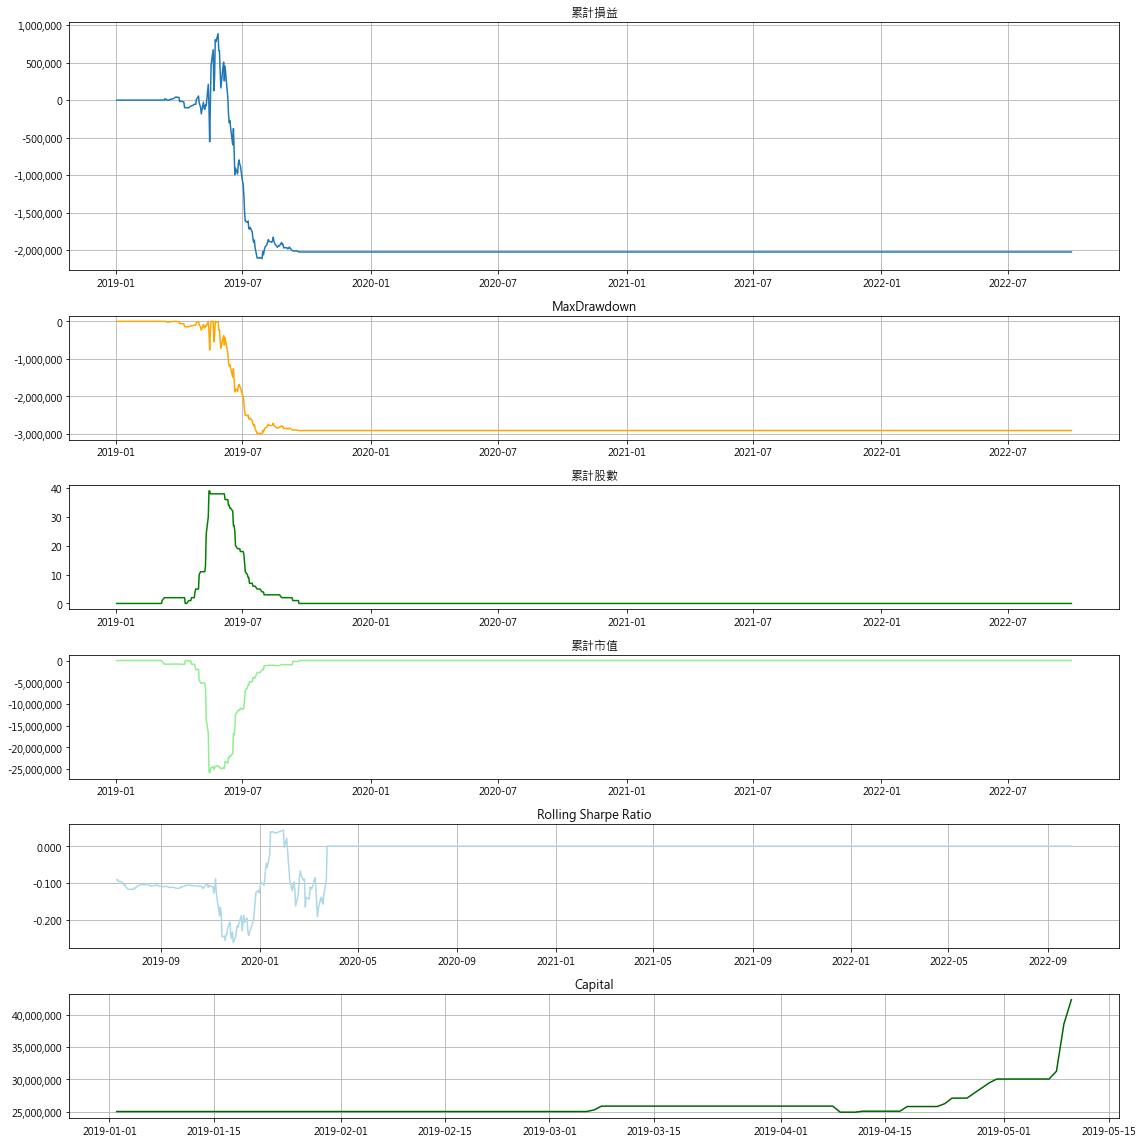

In [46]:
# 用還原收盤價當基準
def backtesting(per_capital: int = 250000, total_capital: int = 100000000):
    f_idx, f_col = chast.data['還原收盤價'].index, chast.data['還原收盤價'].columns
    # 製作空表格，用於計算時存值，最後set回去五個底線dataframe
    def make_df(idx, col):
        return pd.DataFrame(index=idx, columns=col)

    bs = make_df(f_idx, f_col).fillna(0)
    com_ = make_df(f_idx, f_col).fillna(0)
    pf_ = make_df(f_idx, f_col).fillna(0)
    ep_ = make_df(f_idx, f_col).fillna(0)
    ed_ = make_df(f_idx, f_col).fillna(f_idx[0])
    bs_ = make_df(f_idx, f_col).fillna(0)
    eh_ = make_df(f_idx, f_col).fillna(0)
    el_ = make_df(f_idx, f_col).fillna(99999)
    # 存前一根K的時間
    idx1 = f_idx[0]
    # 還原收盤價與收盤價的轉換
    transform = chast.data['收盤價'] / chast.data['還原收盤價']
    transform.replace([np.inf, -np.inf, 0], 1)
    transform.fillna(1)
    # 資金設定 1 億
    # per_capital = 250000
    # total_capital = 100000000
    capital = pd.Series([total_capital] * len(f_idx), index=f_idx)

    ## ----------------------------------------------------------------------------------------------------------------------------------------##
    for idx, row in chast.data['還原收盤價'].iterrows():
        # 用at取代loc，聽說更快
        for col in row.index:
            bs_.at[idx, col] = bs.at[idx1, col]
            bs.at[idx, col] = bs.at[idx1, col]
            ep_.at[idx, col] = ep_.at[idx1, col]
            eh_.at[idx, col] = eh_.at[idx1, col]
            ed_.at[idx, col] = ed_.at[idx1, col]
            el_.at[idx, col] = el_.at[idx1, col]

        capital[idx] = capital[idx1]
        
        # 進場條件1
        entry_mask1 = (bs.loc[idx, :] == 0) &\
            (chast.data['arg_vol'].loc[idx, :] > 50000) & \
            (chast.data['mean_cross_down'].loc[idx, :]) & \
            (chast.data['trend'].loc[idx, :] == 'down') & \
            (chast.data['trend'].loc[idx1, :] != 'down') & \
            (chast.data['20std'].loc[idx, :] >= 0.0001)
        # chast.data['bias'].loc[idx, :].between(-2, -0.5) &\
        # chast.data['bias'].loc[idx, :].between(-2, -0.5) &\
        # 進場條件2
        entry_mask2 = (bs.loc[idx, : ] == 0) &\
            (chast.data['arg_vol'].loc[idx, :] > 50000) & \
            (chast.data['mean_cross_down'].loc[idx, :]) & \
            (chast.data['trend'].loc[idx, :] == 'down') & \
            (chast.data['trend'].loc[idx1, :] == 'down') & \
            (chast.data['l1'].loc[idx, :]) & \
            (chast.data['20std'].loc[idx, :] >= 0.0001)
        
        # 出場條件
        exit_mask = (bs_.loc[idx, :] <= -1) & \
            ((((chast.data['mean_cross_down'].loc[idx, :] == False) & \
            chast.data['h1'].loc[idx, :]) | \
            (chast.data['trend'].loc[idx, :] != 'down'))| \
            (chast.data['20std'].loc[idx, :] <= 0.0001))
        #| \
        #    ((chast.data['還原收盤價'].loc[idx, :] < ep_.loc[idx, :] * 0.5) | \
        #    (chast.data['還原收盤價'].loc[idx, :] > el_.loc[idx, :] * 1.1))

        #print(f'日期 {idx} e1: {entry_mask1.sum()} e2: {entry_mask2.sum()} o1: {exit_mask.sum()}')
        # 當有商品滿足進場條件時執行  
        # print(f'{idx} 買進前: bs: {bs.loc[idx, :].sum()} capital: {capital.at[idx]}')
        if entry_mask1.sum() > 0:
            # 用Sharpe Ratio排序股票，作為買進順序
            for col in chast.data['Sharpe Ratio'].loc[idx, row[entry_mask1].index].rank(ascending=True).sort_values().index:
                # 買進的股數
                contract = np.floor(per_capital / chast.data['收盤價'].at[idx, col] / 1000) * chast.data['std_level'].at[idx, col]
                # 買進花多少錢
                money = contract * 1000 * chast.data['收盤價'].at[idx, col]
                # 目前持倉多少錢
                holding = -((chast.data['收盤價'].loc[idx, :] * bs.loc[idx, :]) * 1000).sum()
                # 若資金足夠、持倉市值沒太大才買進
                if (capital.at[idx] > money) & (holding < total_capital) & (contract >= 1):
                    #print(f'進場1 原本bs: {bs.at[idx, col]}')
                    bs.at[idx, col] = -contract
                    #print(f'進場1 之後bs: {bs.at[idx, col]}')
                    capital.at[idx] += money
                else:
                    pass
                
        if entry_mask2.sum() > 0:
            for col in chast.data['Sharpe Ratio'].loc[idx, row[entry_mask2].index].rank(ascending=True).sort_values().index:
                contract = np.floor(per_capital / chast.data['收盤價'].at[idx, col] / 1000) * chast.data['std_level'].at[idx, col]
                money = contract * 1000 * chast.data['收盤價'].at[idx, col]
                holding = -((chast.data['收盤價'].loc[idx, :] * bs.loc[idx, :]) * 1000).sum()
                if (capital.at[idx] > money) & (holding < total_capital) & (contract >= 1):
                    #print(f'進場2 原本bs: {bs.at[idx, col]}')
                    bs.at[idx, col] = -contract
                    #print(f'進場2 之後bs: {bs.at[idx, col]}')
                    capital.at[idx] += money
                    pass
        # print(f'{idx} 買進後: bs: {bs.loc[idx, :].sum()} capital: {capital.at[idx]}')
        # 當有商品滿足出場條件時執行
        if exit_mask.sum() > 0:
            for col in row[exit_mask].index:
                money = -1 * bs.at[idx, col] * 1000 * chast.data['收盤價'].at[idx, col]
                capital.at[idx] -= money
                #print('+', money, 'then ', capital.at[idx])
                bs.at[idx, col] = 0
                #print(f'出場後 bs: {bs.at[idx, col]}')
                
        for col in row.index:
            # 進場
            if (bs_.at[idx, col] <= -1) & (bs_.at[idx1, col] == 0):
                com_.at[idx, col] = -1 * np.round((0.001425 + 0.003) * bs_.at[idx, col] * 1000 * chast.data['收盤價'].at[idx, col], 2)
                ep_.at[idx, col] = chast.data['還原收盤價'].at[idx, col]
                eh_.at[idx, col] = chast.data['還原收盤價'].at[idx, col]
                el_.at[idx, col] = chast.data['還原收盤價'].at[idx, col]
                ed_.at[idx, col] = idx
            # 出場   
            if (bs_.at[idx, col] == 0) & (bs_.at[idx1, col] <= -1):
                # 借券費用 用3%當基準
                rent_com = (idx - ed_.at[idx, col]).days * 0.03 / 365
                com_.at[idx, col] = -1 * np.round((0.001425 + 0.003 +0.003 + rent_com) * bs_.at[idx1, col] * 1000 * chast.data['收盤價'].at[idx, col], 2)
                # money = np.round(bs_.at[idx1, col] * 1000 * chast.data['收盤價'].at[idx, col], 2)
                # capital.at[idx] += money
                # print(f'出場 capital 剩餘: {capital.at[idx]} 增加資金: {money}')
            
            # 損益計算
            if (bs_.at[idx1, col] <= -1):
                pf_.at[idx, col] = np.round((chast.data['還原收盤價'].at[idx, col] - chast.data['還原收盤價'].at[idx1, col]) * transform.at[idx1, col] * bs_.at[idx1, col] * 1000, 2)
                if chast.data['還原收盤價'].at[idx, col] > eh_.at[idx, col]:
                    eh_.at[idx, col] = chast.data['還原收盤價'].at[idx, col]
                if chast.data['還原收盤價'].at[idx, col] < el_.at[idx, col]:
                    el_.at[idx, col] = chast.data['還原收盤價'].at[idx, col]
        
        idx1 = idx
    ## ----------------------------------------------------------------------------------------------------------------------------------------##
    chast.set_result(pf_, bs_, com_, ep_, ed_, capital)
    chast.get_chart()


# 最佳化
# std level preprocess 如果要改買賣乘數就改labels
# labels = [5, 3.5, 2, 1, 0.5]
labels_test = {
    #'均等': [1, 1.01, 1.02, 0.99, 1.03]
    '10到1': [10, 7, 4, 2, 1],
    #'10': [24, 0.001, 0.0011, 0.0012, 0.0013],
    #'7': [0.001, 24, 0.0011, 0.0012, 0.0014],
    #'4': [0.001, 0.0011, 24, 0.0013, 0.0014],
    #'2': [0.001, 0.0011, 0.0012, 24, 0.0014],
    #'1': [0.001, 0.0011, 0.0012, 0.0013, 24],
    #'猜測最佳結果': [2, 0.6, 0.5, 0.7, 1.8]
}
for k, labels in labels_test.items():
    std_level = chast.data['還原收盤價'].pct_change().rolling(20).std().div(chast.data['還原收盤價'].pct_change().std(axis=1), axis=0).replace([np.inf, -np.inf], 1)
    for i, v in std_level.iterrows():
        # 去除極端值
        v99 = v.quantile(.95)
        v01 = v.quantile(.05)
        mask_99 = v[v > v99].index
        mask_01 = v[v < v01].index
        std_level.loc[i, mask_99] = v99
        std_level.loc[i, mask_01] = v01
    # 把股票按照波動排名，後續用作買的倍率[5, 4, 3, 2, 1]
    std_level = std_level.apply(lambda x: pd.cut(x, bins=5, labels=labels) if x.sum() != 0 else [0] * len(x), axis=0)
    chast.set_data('std_level', std_level)
    print(k, ' 系列開始 ----------------------------------------------------------------')
    for per in [150000]:
        for limit in [25000000]:
            print(f'每單位 {per} 上限 {limit}')
            backtesting(per, limit)
            print('\n\n\n\n\n\n')
            gc.collect()
            

In [47]:
# 持有部位資訊
day = -1
position = pd.DataFrame(list(zip(
    chast.results['BS'].iloc[day][chast.results['BS'].iloc[day] <= -1].index,
    chast.results['BS'].iloc[day][chast.results['BS'].iloc[day] <= -1],
    chast.results['ENTRY DATE'].iloc[day][chast.results['BS'].iloc[day] <= -1],
    chast.results['ENTRY PRICE'].iloc[day][chast.results['BS'].iloc[day] <= -1])), columns=['商品', '持倉張數', '進場日期', '進場價格']).sort_values('進場日期')


new_buy = pd.DataFrame(list(zip(
    chast.results['BS'].iloc[day][(chast.results['BS'].iloc[day] <= -1) & (chast.results['BS'].iloc[day-1] == 0)].index,
    chast.results['BS'].iloc[day][(chast.results['BS'].iloc[day] <= -1) & (chast.results['BS'].iloc[day-1] == 0)])), columns=['商品', '買進張數'])

new_sell = pd.DataFrame(list(zip(
    chast.results['BS'].iloc[day-1][(chast.results['BS'].iloc[day] == 0) & (chast.results['BS'].iloc[day-1] <= -1)].index,
    chast.results['BS'].iloc[day-1][(chast.results['BS'].iloc[day] == 0) & (chast.results['BS'].iloc[day-1] <= -1)])), columns=['商品', '賣出張數'])

display(position)
print(position.shape)
display(new_buy)
display(new_sell)

,商品,持倉張數,進場日期,進場價格


(0, 4)


,商品,買進張數


,商品,賣出張數


In [48]:
(chast.results['PROFIT'] - chast.results['COMMISION']).groupby(pd.Grouper(freq='1y')).sum().sum(axis=1)

日期
2019-12-31   -2,025,455.6200
2020-12-31            0.0000
2021-12-31            0.0000
2022-12-31            0.0000
Freq: A-DEC, dtype: float64